In [74]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits, fetch_openml

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

In [3]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False,download=True, transform=transform)

In [4]:
x = trainset[0][0].reshape(28,28)
x.shape

torch.Size([28, 28])

In [5]:
traindata = [i[0].reshape(-1) for i in trainset]
trainlabel = [i[1] for i in trainset]
testdata = [i[0].reshape(-1) for i in testset]
testlabel = [i[1] for i in testset]

X = traindata + testdata
y = trainlabel + testlabel

In [6]:
X = torch.vstack(X)
X.shape

torch.Size([70000, 784])

In [7]:
len(X), len(y)

(70000, 70000)

<Figure size 640x480 with 0 Axes>

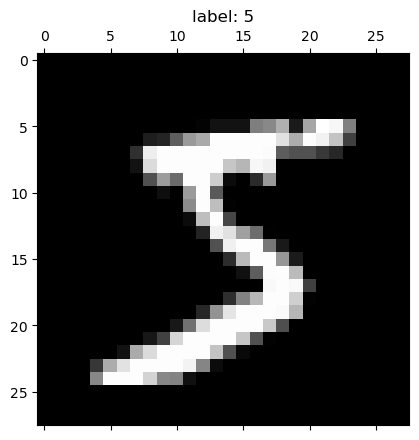

In [8]:
plt.gray()
plt.matshow(X[0].reshape(28,28))
plt.title("label: {}".format(y[0]))
plt.show()

# 1. opencv

In [8]:
# -*- coding: utf-8 -*-
import cv2
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
 
 
def filter_high_f(fshift, radius_ratio):
    """
    过滤掉除了中心区域外的高频信息
    """
    # 1, 生成圆形过滤器, 圆内值1, 其他部分为0的过滤器, 过滤
    template = np.zeros(fshift.shape, np.uint8)
    crow, ccol = int(fshift.shape[0] / 2), int(fshift.shape[1] / 2)  # 圆心
    radius = int(radius_ratio * img.shape[0] / 2)
    if len(img.shape) == 3:
        cv2.circle(template, (crow, ccol), radius, (1, 1, 1), -1)
    else:
        cv2.circle(template, (crow, ccol), radius, 1, -1)
    # 2, 过滤掉除了中心区域外的高频信息
    return template * fshift
 
 
def filter_low_f(fshift, radius_ratio):
    """
    去除中心区域低频信息
    """
    # 1 生成圆形过滤器, 圆内值0, 其他部分为1的过滤器, 过滤
    filter_img = np.ones(fshift.shape, np.uint8)
    crow, col = int(fshift.shape[0] / 2), int(fshift.shape[1] / 2)
    radius = int(radius_ratio * img.shape[0] / 2)
    if len(img.shape) == 3:
        cv2.circle(filter_img, (crow, col), radius, (0, 0, 0), -1)
    else:
        cv2.circle(filter_img, (crow, col), radius, 0, -1)
    # 2 过滤中心低频部分的信息
    return filter_img * fshift
 
 
def ifft(fshift):
    """
    傅里叶逆变换
    """
    ishift = np.fft.ifftshift(fshift)  # 把低频部分sift回左上角
    iimg = np.fft.ifftn(ishift)  # 出来的是复数，无法显示
    iimg = np.abs(iimg)  # 返回复数的模
    return iimg
 
 
def get_low_high_f(img, radius_ratio):
    """
    获取低频和高频部分图像
    """
    # 傅里叶变换
    # np.fft.fftn
    f = np.fft.fftn(img)  # Compute the N-dimensional discrete Fourier Transform. 零频率分量位于频谱图像的左上角
    fshift = np.fft.fftshift(f)  # 零频率分量会被移到频域图像的中心位置，即低频
 
    # 获取低频和高频部分
    hight_parts_fshift = filter_low_f(fshift.copy(), radius_ratio=radius_ratio)  # 过滤掉中心低频
    low_parts_fshift = filter_high_f(fshift.copy(), radius_ratio=radius_ratio)
 
    low_parts_img = ifft(low_parts_fshift)  # 先sift回来，再反傅里叶变换
    high_parts_img = ifft(hight_parts_fshift)
 
    # 显示原始图像和高通滤波处理图像
    img_new_low = (low_parts_img - np.amin(low_parts_img)) / (np.amax(low_parts_img) - np.amin(low_parts_img) + 0.00001)
    img_new_high = (high_parts_img - np.amin(high_parts_img) + 0.00001) / (np.amax(high_parts_img) - np.amin(high_parts_img) + 0.00001)
 
    # uint8
    img_new_low = np.array(img_new_low*255, np.uint8)
    img_new_high = np.array(img_new_high * 255, np.uint8)
    return img_new_low, img_new_high

In [11]:
img.shape

(8849, 9932)

In [43]:
image = cv2.imread('./z.png')

blurred = cv2.GaussianBlur(image, (5, 5), 0)

edges = cv2.Canny(blurred, threshold1=30, threshold2=100)

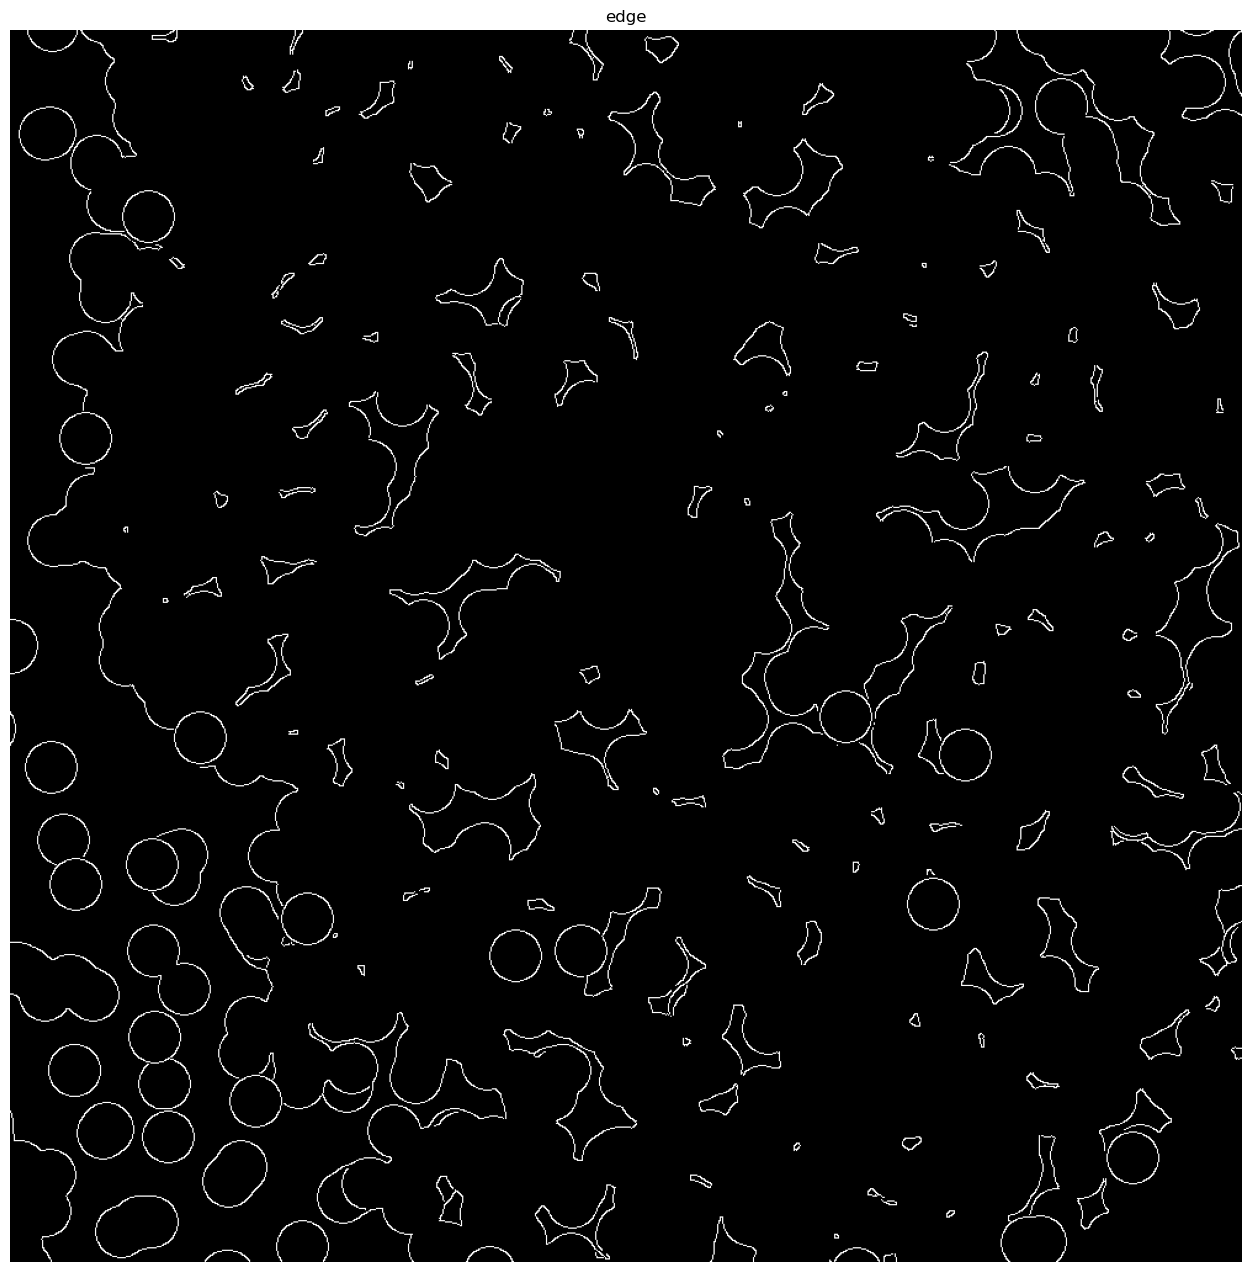

In [45]:
plt.figure(figsize=(16,16))
plt.imshow(edges[4000:5000, 4000:5000], 'gray')
plt.title('edge')
plt.axis('off')
plt.show()

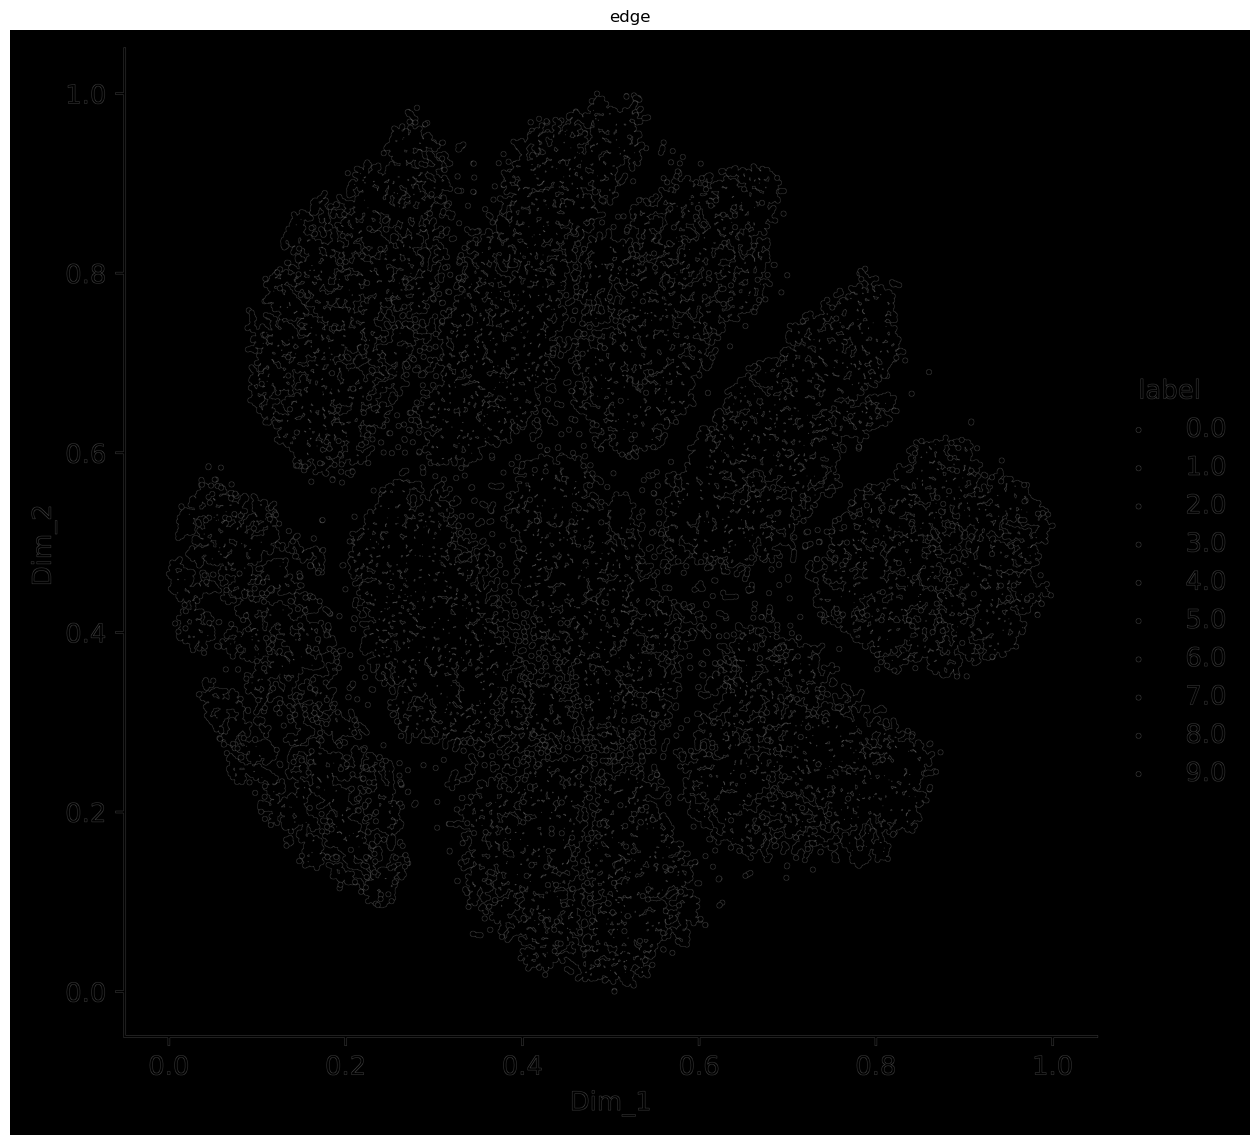

In [44]:
plt.figure(figsize=(16,16))
plt.imshow(edges, 'gray')
plt.title('edge')
plt.axis('off')
plt.show()

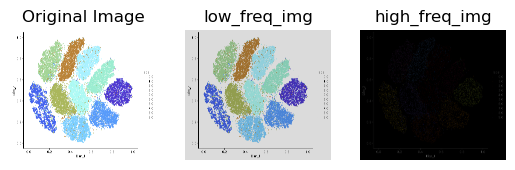

In [18]:
# if __name__ == '__main__':
radius_ratio = 0.5  # 圆形过滤器的半径：ratio * w/2
# img = cv.imread('./z.png', cv2.IMREAD_GRAYSCALE)
img = cv.imread('./z.png')
low_freq_part_img, high_freq_part_img = get_low_high_f(img, radius_ratio=radius_ratio)  # multi channel or single

plt.subplot(131), plt.imshow(img, 'gray'), plt.title('Original Image')
plt.axis('off')
plt.subplot(132), plt.imshow(low_freq_part_img, 'gray'), plt.title('low_freq_img')
plt.axis('off')
plt.subplot(133), plt.imshow(high_freq_part_img, 'gray'), plt.title('high_freq_img')
plt.axis('off')
plt.show()

In [31]:
# if __name__ == '__main__':
radius_ratio = 0.5  # 圆形过滤器的半径：ratio * w/2
img = cv.imread('./I_hat.png', cv2.IMREAD_GRAYSCALE)
low_freq_part_img, high_freq_part_img = get_low_high_f(img, radius_ratio=radius_ratio)  # multi channel or single

plt.subplot(131), plt.imshow(img, 'gray'), plt.title('Original Image')
plt.axis('off')
plt.subplot(132), plt.imshow(low_freq_part_img, 'gray'), plt.title('low_freq_img')
plt.axis('off')
plt.subplot(133), plt.imshow(high_freq_part_img, 'gray'), plt.title('high_freq_img')
plt.axis('off')
plt.show()

MemoryError: Unable to allocate 5.17 GiB for an array with shape (17855, 19415) and data type complex128

# 2. kd-tree

In [100]:
I_hat = np.load("./tsne_data_reducted_normalised.npy")
I_hat.shape

(70000, 3)

In [101]:
I_hat

array([[0.54000233, 0.45737847, 5.        ],
       [0.83101381, 0.5242549 , 0.        ],
       [0.67143392, 0.86606263, 4.        ],
       ...,
       [0.51220249, 0.67433806, 4.        ],
       [0.40750978, 0.54382727, 5.        ],
       [0.63283682, 0.63406221, 6.        ]])

In [102]:
from sklearn.neighbors import KDTree

In [111]:
topk = 1000
r = 0.1

tree = KDTree(I_hat[:, :2], metric='euclidean')

In [160]:
def calc_entropy(arr):
    """calculate entropy for an array

    :param arr: an array containing values
    :return: entropy value
    """
    _, counts = np.unique(arr, return_counts=True)
    probabilities = counts / len(arr)
    shannon_entropy = -np.sum(probabilities * np.log2(probabilities))
    return shannon_entropy


def calc_ent(I_hat, topk=1000, radius=None):
    """calculate entropy array for I_hat

    :param I_hat: (n, 3) -- 2D coordinate and label
    :param topk: nearest k datapoints for entropy calculation, defaults to 1000
    :param radius: datapoints within radius for entropy calcuulation, defaults to None
    :return: a list [(idx in I_hat, pos_x, pos_y, label)]
    """
    ents = []

    for i in tqdm(range(len(I_hat))):
        # label of this datapoint
        x = I_hat[i, 0]
        y = I_hat[i, 1]
        label = int(I_hat[i, 2])

        # find k nearest neighbours for this datapoint
        
        # delete same-class data and calculate entropy
        if topk!=None and radius==None:
            dist, ind = tree.query(I_hat[i, :2].reshape(1,-1), k=topk)
            array = np.delete(I_hat[:, 2][ind].astype(int).reshape(-1), label)
        elif topk==None and radius!=None:
            dist, ind = tree.query_radius(I_hat[i, :2].reshape(1,-1), r=r, count_only=False, return_distance=True)
            array = np.delete(I_hat[:, 2][list(ind.item())].astype(int).reshape(-1), label)
        else:
            print("[warning] must assign topk or radius")
            exit()
        entropy = calc_entropy(arr=array)

        # save
        ents.append((i, entropy, x, y, label))

    # sort entropy array
    sorted_ents = sorted(ents, key=lambda x:x[1], reverse=True)

    return sorted_ents

In [161]:
# sorted_ents = sorted(ents, key=lambda x:x[1], reverse=True)
sorted_ents = calc_ent(I_hat=I_hat, topk=topk, radius=None)
sorted_ents[:10], sorted_ents[-10:]

100%|██████████| 70000/70000 [00:16<00:00, 4126.24it/s]


([(19702, 2.1389261276949076, 0.6222952826821658, 0.4213693141773465, 5),
  (50202, 2.1382143954330433, 0.6231438529324451, 0.42132242664209085, 5),
  (33340, 2.136927231038075, 0.6243242930595, 0.42114692956424965, 5),
  (50734, 2.1366795282681648, 0.6235084928526531, 0.4213362522145638, 5),
  (29120, 2.1344149444251443, 0.6240518954001505, 0.42138549065687964, 5),
  (38280, 2.1342281283910784, 0.6237396662586645, 0.421239221324354, 5),
  (38656, 2.1338477924632855, 0.6240305425321099, 0.4213286304246108, 5),
  (33598, 2.132250853198519, 0.6239562732295607, 0.42125829912172724, 5),
  (25330, 2.131910850712069, 0.6249178708548734, 0.42082320406466606, 5),
  (33928, 2.1309161107233905, 0.6252732936459188, 0.4206542652712031, 5)],
 [(52485, -0.0, 0.34232973930942534, 0.39598215803342074, 8),
  (55557, -0.0, 0.32891863008373023, 0.3980331192055039, 8),
  (55632, -0.0, 0.33124213616540316, 0.39743238781965945, 8),
  (56771, -0.0, 0.3429959186303676, 0.39578516694817223, 8),
  (58446, -0.0,

In [169]:
_, k_inds = tree.query(I_hat[sorted_ents[100][0]][:2].reshape(1, -1), k=topk+1)

kneighbours = I_hat[k_inds]

In [167]:
def draw_Ihat(I_hat):
    plt.figure(figsize=(16,16), dpi=1500)
    sn.heatmap(I_hat, cmap=sn.color_palette("rocket_r", as_cmap=True))
    plt.show()

def draw_z(z, cls, s=25, x_highlight=0.0, y_highlight=0.0):
    """draw data and labels

    :param z: (n, 2) -- 2D data
    :param cls: (n, ) -- label/class for datapoints
    :param s: size, defaults to 25
    """

    # re-organise as df
    try:
        tsne_data = np.hstack((z.numpy(), cls.reshape((-1,1)).numpy()))
    except:
        tsne_data = np.hstack((z, cls.reshape((-1,1))))

    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    tsne_df = tsne_df.sort_values("label")

    # draw
    plt.figure(dpi=1500)
    
    # main figure
    sn.FacetGrid(tsne_df, hue="label", height=6, palette="Spectral").map(plt.scatter, "Dim_1", "Dim_2", s=s).add_legend()
    # highlights
    plt.scatter(x_highlight, y_highlight, marker='*', s=20, c='black', label='Highlighted Point')

    # dpi    
    matplotlib.rcParams["figure.dpi"] = 1500
    
    # axes range
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    
    plt.show()

In [171]:
draw_z(z=kneighbours[0][:, :2], cls=kneighbours[0][:, 2], s=1, x_highlight=sorted_ents[100][2], y_highlight=sorted_ents[100][3])

<Figure size 9600x7200 with 0 Axes>

In [158]:
draw_z(z=kneighbours[0][:, :2], cls=kneighbours[0][:, 2], s=1, x_highlight=sorted_ents[0][2], y_highlight=sorted_ents[0][3])

<Figure size 9600x7200 with 0 Axes>